In [1]:
%matplotlib inline

In [2]:
from __future__ import division,print_function

import os, json
import shutil
from glob import glob
import random
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from importlib import reload
import utils; reload(utils)
from utils import plots

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla P100-PCIE-16GB (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [4]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam, Nadam


## Create validation set and sample

In [5]:
NB_ROOT = os.getcwd()

In [6]:
DATA_HOME_DIR = os.path.join(NB_ROOT, "data/invasive-species-monitoring")
results_path = os.path.join('/mnt/data/invasive-species-monitoring', 'results/')

In [7]:
%cd $DATA_HOME_DIR
%mkdir -p valid
%mkdir -p results
%mkdir -p sample/train
%mkdir -p sample/test/unknown
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown
%mkdir -p /mnt/data/invasive-species-monitoring/results

/mnt/ml/working/fastai-courses/deeplearning1/nbs/data/invasive-species-monitoring


In [8]:
def create_label_dirs(base_dir):
    """
    """
    # Create label directories thant can be recognized by Keras ImageDataGenerator.flow_from_directory    
    labels = ['invasive', 'not_invasive']
    for label in labels:
        try:
            os.makedirs(os.path.join(base_dir, label))
        except OSError as e:
            if e.errno != os.errno.EEXIST:
                raise

create_label_dirs('train')
create_label_dirs('valid')
create_label_dirs('sample/train')
create_label_dirs('sample/valid')

In [9]:
train_labels_csv = pd.read_csv("train_labels.csv")

In [10]:
def label_images_by_dir(base_dir="train"):
    """
    Move images into their label directory so that they can be recognized by
    ImageDataGenerator.flow_from_directory
    """
    for _, row in train_labels_csv.iterrows():
        image_name = "{}.jpg".format(row['name'])
        src_path = os.path.join(base_dir, image_name)
        if row['invasive'] == 1:
            dst_path = os.path.join(base_dir, 'invasive', image_name)
        else:
            dst_path = "train/not_invasive/{}".format(image_name)
        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)
# label_images_by_dir()

In [11]:
def create_valid_set(train_root='train', valid_root="valid", valid_rate=0.1):
    labels = ['invasive', 'not_invasive']
    for label in labels:
        train_label_dir = os.path.join(train_root, label)
        valid_label_dir = os.path.join(valid_root, label)
        files = os.listdir(train_label_dir)
        for file in random.sample(files, k=int(len(files) * valid_rate)):
            shutil.move(os.path.join(train_label_dir, file), valid_label_dir)
# create_valid_set()

In [12]:
def create_sample_set(rate=0.01):
    labels = ['invasive', 'not_invasive', 'unknown']
    for dataset in ['train', 'valid', 'test']:
        if dataset == "valid":
            # use a higher smple rate for the validation dataset
            # because they have fewer items
            sample_rate = rate*5
        else:
            sample_rate = rate
        for label in labels:
            src_dir = os.path.join(dataset, label)
            dst_dir = os.path.join('sample', dataset, label)
            try:
                files = os.listdir(src_dir)
            except FileNotFoundError:
                continue
            for file in random.sample(files, k=int(len(files) * sample_rate)):
                shutil.copy(os.path.join(src_dir, file), dst_dir)

# create_sample_set()

# Build Model

In [13]:
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr


In [14]:
def addConvBlock(model, layers, filters):
    """
        Adds a specified number of ZeroPadding and Covolution layers
        to the model, and a MaxPooling layer at the very end.

        Args:
            layers (int):   The number of zero padded convolution layers
                            to be added to the model.
            filters (int):  The number of convolution filters to be 
                            created for each layer.
    """
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [15]:
def addFCBlock(model):
    """
        Adds a fully connected layer of 4096 neurons to the model with a
        Dropout of 0.5

        Args:   None
        Returns:   None
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))


In [16]:
# Build Vgg model
def build_model(input_shape=(3,224,224)):
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=input_shape, output_shape=input_shape))

    addConvBlock(model, 2, 64)
    addConvBlock(model, 2, 128)
    addConvBlock(model, 3, 256)
    addConvBlock(model, 3, 512)
    addConvBlock(model, 3, 512)

    model.add(Flatten())


    addFCBlock(model)
    addFCBlock(model)

    model.add(Dense(1000, activation='softmax'))

    fname = 'vgg16.h5'
    model.load_weights(get_file(fname, 'http://files.fast.ai/models/'+fname, cache_subdir='models'))
    return model

In [17]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, target_size=(224,224), class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        # 224x224 is the image size used by ImageNet
        return gen.flow_from_directory(path, target_size=target_size,
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

# Train

In [18]:
_path = DATA_HOME_DIR
# _path = DATA_HOME_DIR + '/sample' # Only for sample tests!
test_path = os.path.join(DATA_HOME_DIR, 'test')
train_path = os.path.join(_path, 'train')
valid_path = os.path.join(_path, 'valid')
test_path = os.path.join(_path, 'test')

In [19]:
! cd $NB_ROOT
BATCH_SIZE=16

trans_gen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1, height_shift_range=0.1,
    horizontal_flip=True,
)
target_size = (600, 450)
#target_size = (224, 224) 
train_batches = get_batches(train_path, batch_size=BATCH_SIZE, target_size=target_size)
valid_batches = get_batches(valid_path, batch_size=BATCH_SIZE*2, target_size=target_size)

Found 2067 images belonging to 2 classes.
Found 228 images belonging to 2 classes.


In [20]:
from keras.preprocessing import image

def plot_species(batch, label, rows=1):
    class_ = batch.class_indices[label]
    filenames = batch.filenames
    idx = np.where(batch.classes==class_)[0]
    idx = np.random.permutation(idx)[:20]
    plots(
        [image.load_img(os.path.join(train_path, filenames[i])) for i in idx],
        figsize=(24,12), rows=rows)
    

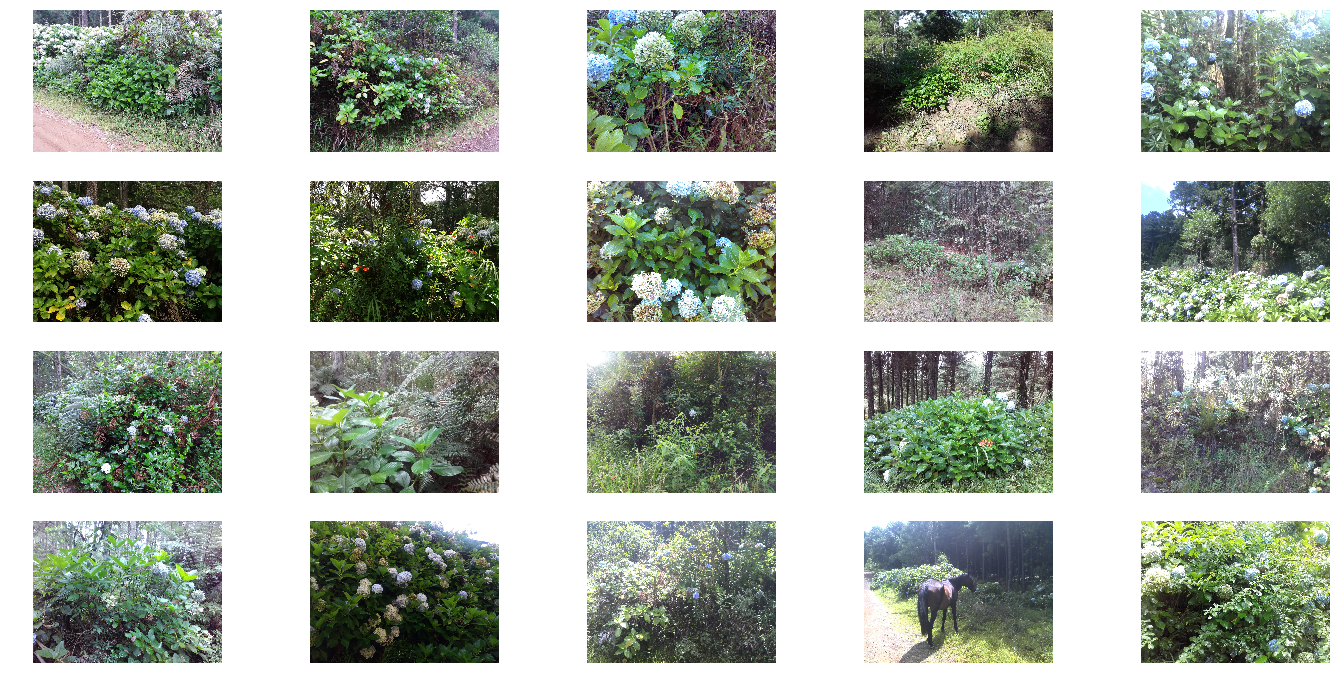

In [21]:
plot_species(train_batches, 'invasive', rows=4)

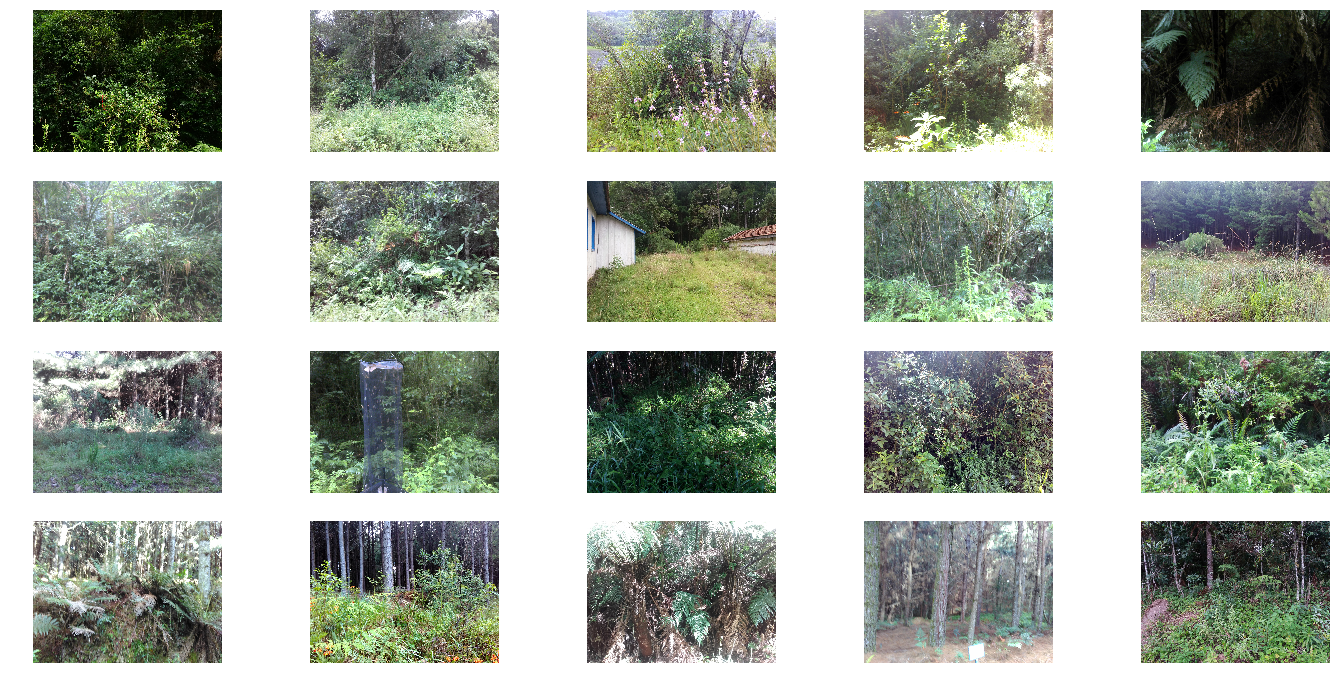

In [22]:
plot_species(train_batches, 'not_invasive', rows=4)

In [29]:
input_shape = (3,) + target_size
model = build_model(input_shape)

/mnt/ml/libs/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/mnt/ml/libs/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/mnt/ml/libs/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/mnt/ml/libs/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`


In [30]:
def finetune(model, output_size, lr=0.001):
    while not isinstance(model.layers[-1], Flatten):
        model.pop()
    for layer in model.layers:
        layer.trainable = False
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(
        optimizer=RMSprop(),
        loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
finetune(model, train_batches.num_classes)

In [32]:
def fit_model(model, no_of_epochs = 10):
    latest_weights_filename = None
    for epoch in range(no_of_epochs):
        print("Running epoch: %d" % epoch)
        model.fit_generator(
            train_batches,
            epochs=1,
            steps_per_epoch=train_batches.samples//BATCH_SIZE,
            validation_data=valid_batches, validation_steps=valid_batches.samples//BATCH_SIZE,
        )
        latest_weights_filename = 'oldft%d.h5' % epoch
        model.save_weights(os.path.join(results_path, latest_weights_filename))
        print("Completed %s fit operations" % epoch)

In [ ]:
fit_model(model, 10)

Running epoch: 0
Epoch 1/1
 82/129 [==================>...........] - ETA: 6:03 - loss: 6.1464 - acc: 0.6113

# Training more dense layer

In [82]:
first_dense_idx = [index for index,layer in enumerate(model.layers) if isinstance(layer, Dense)][0]
for layer in model.layers[first_dense_idx:]:
    layer.trainable = True


In [83]:
fit_model(model, 50)

Running epoch: 0
Epoch 1/1
2067/2067 [==============================] - 84s - loss: 0.4986 - acc: 0.9071 - val_loss: 0.5407 - val_acc: 0.8816
Completed 50 fit operations
Running epoch: 1
Epoch 1/1
2067/2067 [==============================] - 84s - loss: 0.5567 - acc: 0.8999 - val_loss: 0.4910 - val_acc: 0.8904
Completed 50 fit operations
Running epoch: 2
Epoch 1/1
2067/2067 [==============================] - 84s - loss: 0.5313 - acc: 0.9124 - val_loss: 0.7242 - val_acc: 0.8421
Completed 50 fit operations
Running epoch: 3
Epoch 1/1
2067/2067 [==============================] - 84s - loss: 0.5431 - acc: 0.9066 - val_loss: 0.6994 - val_acc: 0.8640
Completed 50 fit operations
Running epoch: 4
Epoch 1/1
2067/2067 [==============================] - 84s - loss: 0.5454 - acc: 0.9018 - val_loss: 0.4006 - val_acc: 0.8860
Completed 50 fit operations
Running epoch: 5
Epoch 1/1
2067/2067 [==============================] - 84s - loss: 0.5515 - acc: 0.9013 - val_loss: 0.3754 - val_acc: 0.9211
Complete

KeyboardInterrupt: 

In [68]:
model.load_weights(os.path.join(results_path, 'ft7.h5'))

# Predict

In [69]:
test_batches = get_batches(
    test_path, batch_size=BATCH_SIZE * 2, target_size=target_size, shuffle=False, class_mode=None)

Found 1531 images belonging to 1 classes.


In [70]:
def predict(model, test_batches):
    return model.predict_generator(test_batches, test_batches.nb_sample)
    

In [71]:
preds = predict(model, test_batches)

In [72]:
sbm = pd.DataFrame(preds, columns=["invasive","not invasive"])
sbm['name'] = [int(f.replace('unknown/', '').replace('.jpg', '')) for f in test_batches.filenames]
sbm = sbm.set_index(['name'])
sbm = sbm.sort_index()

In [73]:
sbm.to_csv('submission.csv', columns=['invasive'])

In [74]:
!kg submit -c invasive-species-monitoring submission.csv

0.95541
